<h1><center>
    Implementing, and using GNN architectures. <br/>
  
    
    Project 3
</center></h1>

# Theory Question 1
<img src="https://i.stack.imgur.com/HIV6k.png" width="300">

Given the graph above with and without coloring, describe which machine learning algorithms preserve the topological information irrespective of the geometric visualization. Here and in the following different colored edges represent different edge relations. Please consider the graph that is visualized and not the picture of the graph.


First we can consider the graph witout colour. This is a fully connected graph, where each node is connected by an edge. In other words, every vertex in a fully connected graph is directly connected to every other vertex. Since there is no specific ordering, there are no permutations to consider. Therefore we can use a variety of machine learning approaches that work well for fully connected graphs where permutations are not an issue such as Graph Convolutional Networks (GCNs) and Deep Sets.  <br>

Considering the red and the blue edges, as different edges, not all nodes are connected the same way. Here networks that are permutationally invariant, are important. Specifically Graph Convolutional Networks (GCNs) and Graph Attention Networks (GATs) are capable of working with the coloured graph (i.e. red or blue) as they contain some permutation invariance. Graph Attention Networks combine elements of Transformers into their architecture to better process topological information with attention. A readout mechanism is used to generate a fixed-length representation of the entire graph (embedding) and in combination with the attention, permutation invariance can be achieved. 

In conclusion both Graph Convolutional Networks (GCNs) and Graph Attention Networks (GATs) can work with both the coloured version and the uncoloured version of the above graph as they are permutationally invariant and work with fully connected graphs.



# Task 1.1
Given the graph visualized in Theory Question 1. Visualize the graph in a datastructure of your choice, if your result does not match the geometry in the figure construct an isomorphism between the two graphs.

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [16]:
red_graph = np.array([[0, 1, 0, 0, 1],
                    [1, 0, 1, 0, 0],
                    [0, 1, 0, 1, 0],
                    [0, 0, 1, 0, 1],
                    [1, 0, 0, 1, 0]])

blue_graph = np.array([[0, 0, 1, 1, 0],
                    [0, 0, 0, 1, 1],
                    [1, 0, 0, 0, 1],
                    [1, 1, 0, 0, 0],
                    [0, 1, 1, 0, 0]])

no_colour_graph = blue_graph + red_graph
no_colour_graph

array([[0, 1, 1, 1, 1],
       [1, 0, 1, 1, 1],
       [1, 1, 0, 1, 1],
       [1, 1, 1, 0, 1],
       [1, 1, 1, 1, 0]])

In [17]:
# red edges = 1, blue edges = -1, no edges = 0
coloured_graph = red_graph - blue_graph
coloured_graph

array([[ 0,  1, -1, -1,  1],
       [ 1,  0,  1, -1, -1],
       [-1,  1,  0,  1, -1],
       [-1, -1,  1,  0,  1],
       [ 1, -1, -1,  1,  0]])

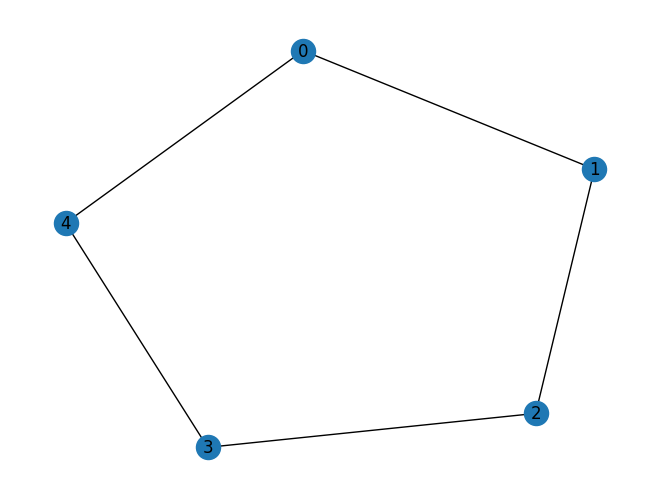

In [7]:

G = nx.Graph(red_graph)
nx.draw(G, with_labels=True)
plt.show()

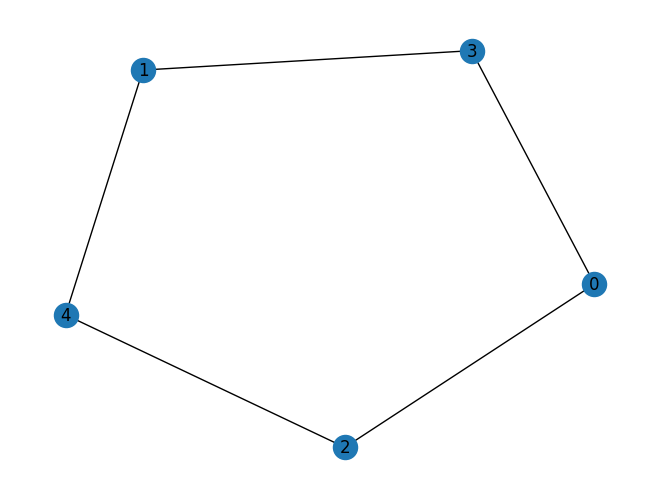

In [8]:
G = nx.Graph(blue_graph)
nx.draw(G, with_labels=True)
plt.show()

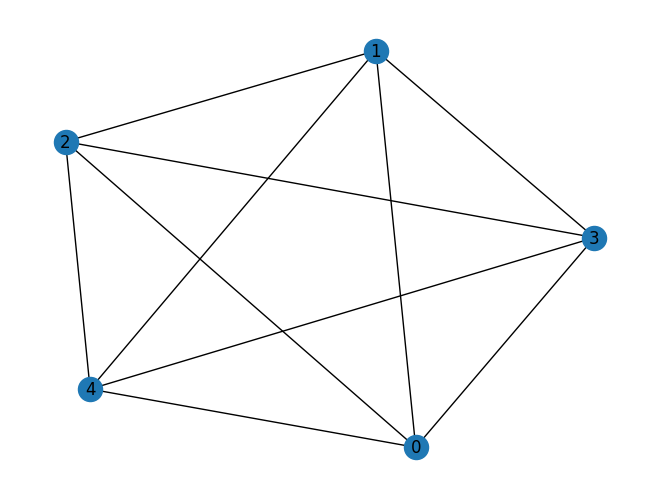

In [9]:
G = nx.Graph(no_colour_graph)
nx.draw(G, with_labels=True)
plt.show()

# Task 1.2
Given the graph shown in the image of theory question 1. Implement from scratch using <b>only numpy</b> both graph convolutions when respecting the coloring and without respecting the coloring (edge relation).

# Task 1.2.1
Graph Convolution without edge coloring.

In [10]:
# Define the feature matrix
# we only have 1 feature per node and all are 1
feature_matrix = np.array([[1], [1], [1], [1], [1]])

# Initialize the weight matrices using xaiver initialization
W1 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W2 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W3 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W4 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W5 = np.array([np.random.normal(0, 1/ len(feature_matrix))])

# Compute the output feature matrix
Z1 = np.dot(no_colour_graph, np.dot(feature_matrix, W1))
Z2 = np.dot(no_colour_graph, np.dot(feature_matrix, W2))
Z3 = np.dot(no_colour_graph, np.dot(feature_matrix, W3))
Z4 = np.dot(no_colour_graph, np.dot(feature_matrix, W4))
Z = Z1 + Z2 + Z3 + Z4
# sigma activation function
output = 1 / (1 + np.exp(-Z))
output


array([0.15551107, 0.15551107, 0.15551107, 0.15551107, 0.15551107])

# Task 1.2.2
Graph Convolution with edge coloring.

In [14]:
coloured_graph.shape

(5, 5)

In [15]:
# Define the feature matrix
# we only have 1 feature per node and all are 1
feature_matrix = np.array([[1], [1], [1], [1], [1]])

# Initialize the weight matrices using xaiver initialization
W1 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W2 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W3 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W4 = np.array([np.random.normal(0, 1/ len(feature_matrix))])
W5 = np.array([np.random.normal(0, 1/ len(feature_matrix))])

# Compute the output feature matrix
Z1 = np.dot(coloured_graph, np.dot(feature_matrix, W1))
Z2 = np.dot(coloured_graph, np.dot(feature_matrix, W2))
Z3 = np.dot(coloured_graph, np.dot(feature_matrix, W3))
Z4 = np.dot(coloured_graph, np.dot(feature_matrix, W4))
Z = Z1 + Z2 + Z3 + Z4
# sigma activation function
output = 1 / (1 + np.exp(-Z))
output

array([0.5, 0.5, 0.5, 0.5, 0.5])

# Task 2

We will now reinterpret the exercise that we had in the last assignment.

In the following, we want to train a GNN using the [Deep Graph Library (DGL)](https://github.com/dmlc/dgl) using the data set from last week  ([Tensorflow version](https://www.tensorflow.org/datasets/catalog/yelp_polarity_reviews) and [(py)torch version](https://pytorch.org/text/stable/datasets.html#yelpreviewpolarity).

Recap:
Given the text of a review, we want to determine whether the yelp review is positive and negative. The data set is pre-split into training and test set. Please use the training data to fine-tune your model, while using the test data to evaluate your models performance. This exercise does not necessarily end in having a SOTA model, the goal is for you to use and fine-tune SOTA pretrained large language models.

Problem Setting:

The label $y$ to a Yelp review $T$ is either positive or negative. Given a Yelp Review $T$ and a polarity feedback $y$ determine whether the Review $T$ is positive or negative. The training set $\mathcal{D} = \{(T_1, y_1), \ldots, (T_N, y_N)\}$, where $T_i$ is review $i$ and $y_i$ is $T_i$'s polarity feedback. Use <b>AUC</b> as Evaluation Metric.

In the following, please solve all subtasks as well as the .

## Task 2.0
Load the Yelp Review Polarity dataset. Here it is also possible to only use part of the data (e.g. 5%)

In [1]:
from torchtext.datasets import YelpReviewPolarity
import torch

# Load YelpReviewPolarity dataset, split into train and test
# datatype: ShardingFilterIterDataPipe
train_data, test_data = YelpReviewPolarity(root='.data', split=('train', 'test'))

percentage_to_use = 0.000005 #change nr if you want more/less train data

train_split_index = int(len(list(train_data)) * percentage_to_use)
test_split_index = int(len(list(test_data)) * percentage_to_use)

## Task 2.1
Reinterpret the text data as graph data using DGL.

In [2]:
import dgl
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

train_graphs = []
train_split_index = max(train_split_index, 100)
train_data = list(train_data)[:train_split_index] 

for i in range(len(train_data)):
    if i % 100 == 0:
        print('Train progess: ', i, ' of ', len(train_data))
    # split train data instance into label and text inputs
    label, inputs = train_data[i]

    # tokenize text
    tokenized_inputs = tokenizer(inputs, padding=True, add_special_tokens=True,  truncation=True, return_tensors="pt")

    # get embeddings for tokens
    mask = tokenized_inputs['attention_mask']
    input_id = tokenized_inputs['input_ids']
    output = model(input_id, mask)

    # initialize graph with nodes
    g = dgl.DGLGraph()
    g.add_nodes(len(output['last_hidden_state'][0]), {'lhs': output['last_hidden_state'][0]})

    # get lists of edge sources and destinations (every token has a directed edge to the succeding token)
    edge_src = list(range(0, len(output['last_hidden_state'][0])))
    edge_dst = list(range(1, len(output['last_hidden_state'][0]) + 1))

    # add the edges
    g.add_edges(edge_src, edge_dst)

    # add self-loop to avoid having 0 in-degree nodes
    g = dgl.add_self_loop(g)
    
    # append graph of this review to list
    train_graphs.append((g, label))


test_graphs = []
test_split_index = max(test_split_index, 50)
test_data = list(test_data)[:test_split_index] 

for i in range(len(test_data)):
    if i % 100 == 0:
        print('Test progess: ', i, ' of ', len(test_data))
    # split test data instance into label and text inputs
    label, inputs = test_data[i]

    # tokenize text
    tokenized_inputs = tokenizer(inputs, padding=True, add_special_tokens=True,  truncation=True, return_tensors="pt")

    # get embeddings for tokens
    mask = tokenized_inputs['attention_mask']
    input_id = tokenized_inputs['input_ids']
    output = model(input_id, mask)

    # initialize graph with nodes
    g = dgl.DGLGraph()
    g.add_nodes(len(output['last_hidden_state'][0]), {'lhs': output['last_hidden_state'][0]})

    # get lists of edge sources and destinations (every token has a directed edge to the succeding token)
    edge_src = list(range(0, len(output['last_hidden_state'][0])))
    edge_dst = list(range(1, len(output['last_hidden_state'][0]) + 1))

    # add the edges
    g.add_edges(edge_src, edge_dst)

    # add self-loop to avoid having 0 in-degree nodes
    g = dgl.add_self_loop(g)
    # append graph of this review to list
    test_graphs.append((g, label))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train progess:  0  of  100


/opt/anaconda3/envs/venv_advml/lib/python3.10/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Test progess:  0  of  50


## Task 2.2

Split the data according to your evaluation protocol. Explain whether this task is inductive or transductive.

In [3]:
from sklearn.model_selection import train_test_split

# Split the training data into training and validation sets
train_graphs_split, val_graphs = train_test_split(train_graphs, test_size=0.2, random_state=42)

# Extract the labels from the data
train_labels = torch.tensor([label for _, label in train_graphs_split])
val_labels = torch.tensor([label for _, label in val_graphs])

# subtract 1 from each element of the labels to get labels in range [0, 1]
train_labels = train_labels - 1
val_labels = val_labels - 1

# Create DGLGraph batches for training, validation, and test sets
train_batched_graph = dgl.batch([gr for gr, _ in train_graphs_split])
val_batched_graph = dgl.batch([gr for gr, _ in val_graphs])
test_batched_graph = dgl.batch([gr for gr, _ in test_graphs])

## Task 2.3
Implement, evaluate (with the evaluation protocol you defined in Theory Question 2) and train a GCN architecture for the Yelp data set and the problem setting defined above.

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn.pytorch as dglnn
import torch.optim as optim
from sklearn.metrics import roc_auc_score

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, g, features):
        x = F.relu(self.conv1(g, features))
        x = F.relu(self.conv2(g, x))
        g.ndata['h'] = x
        hg = dgl.mean_nodes(g, 'h')
        return self.fc(hg)

# Initialize the GCN model
in_feats = 768  # Assuming each token is represented by a 768-dimensional vector
hidden_size = 128
num_classes = 2
model = GCN(in_feats, hidden_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(train_batched_graph, train_batched_graph.ndata['lhs'])
    loss = criterion(logits, train_labels)
    loss.backward(retain_graph=True)
    optimizer.step()

    # evaluation on the validation set
    model.eval()
    with torch.no_grad():
        # get logits and loss on the validation set
        logits = model(val_batched_graph, val_batched_graph.ndata['lhs'])
        val_loss = criterion(logits, val_labels)
        # get the auc score on the validation set
        val_prob = F.softmax(logits, dim=1)[:, 1]
        val_auc = roc_auc_score(val_labels.numpy(), val_prob.numpy())

    # print the epoch, loss, val_loss and validation auc score
    print(f"Epoch {epoch+1}/{num_epochs}: Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val AUC: {val_auc:.4f}")


Epoch 1/10: Loss: 0.6743, Val Loss: 1.3607, Val AUC: 0.8352
Epoch 2/10: Loss: 1.4136, Val Loss: 0.6217, Val AUC: 0.8901
Epoch 3/10: Loss: 0.6001, Val Loss: 0.6409, Val AUC: 0.9011
Epoch 4/10: Loss: 0.6135, Val Loss: 0.5738, Val AUC: 0.9011
Epoch 5/10: Loss: 0.5449, Val Loss: 0.5134, Val AUC: 0.9011
Epoch 6/10: Loss: 0.4720, Val Loss: 0.4407, Val AUC: 0.9121
Epoch 7/10: Loss: 0.3697, Val Loss: 0.4324, Val AUC: 0.9011
Epoch 8/10: Loss: 0.3117, Val Loss: 0.4483, Val AUC: 0.8901
Epoch 9/10: Loss: 0.2889, Val Loss: 0.4366, Val AUC: 0.9011
Epoch 10/10: Loss: 0.1954, Val Loss: 0.5475, Val AUC: 0.9011


# Theory Question 2
Given a graph with N vertices and M edges, for three different aggregation functions prove that they are permutation invariant.

# Task 3
In the following,  we will use a dataset as well as pre-defined task. You can find the dataset as well as the task under ogbl-collab [here](https://ogb.stanford.edu/docs/linkprop/#ogbl-collab). Split the data, use their evaluation metric as well as train a GCN for link prediction. 

# Task 3.1
Load and split the data

In [ ]:
# incorporated in task 3.2

# Task 3.2
Implement, train and evaluate using the data (from Task 4.1.) a GCN using the edge and node information in a geometric DL package of your choice.

In [1]:
from torch_sparse import SparseTensor
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

# 
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)

def train(model, predictor, data, split_edge, optimizer, batch_size):
    model.train()
    predictor.train()

    pos_train_edge = split_edge['train']['edge'].to(data.x.device)

    total_loss = total_examples = 0
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size,
                           shuffle=True):
        optimizer.zero_grad()

        h = model(data.x, data.adj_t)

        edge = pos_train_edge[perm].t()

        pos_out = predictor(h[edge[0]], h[edge[1]])
        pos_loss = -torch.log(pos_out + 1e-15).mean()

        # Just do some trivial random sampling.
        edge = torch.randint(0, data.num_nodes, edge.size(), dtype=torch.long,
                             device=h.device)
        neg_out = predictor(h[edge[0]], h[edge[1]])
        neg_loss = -torch.log(1 - neg_out + 1e-15).mean()

        loss = pos_loss + neg_loss
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)

        optimizer.step()

        num_examples = pos_out.size(0)
        total_loss += loss.item() * num_examples
        total_examples += num_examples

    return total_loss / total_examples

@torch.no_grad()
def test(model, predictor, data, split_edge, evaluator, batch_size):
    model.eval()
    predictor.eval()

    h = model(data.x, data.adj_t)

    pos_train_edge = split_edge['train']['edge'].to(h.device)
    pos_valid_edge = split_edge['valid']['edge'].to(h.device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(h.device)
    pos_test_edge = split_edge['test']['edge'].to(h.device)
    neg_test_edge = split_edge['test']['edge_neg'].to(h.device)

    pos_train_preds = []
    for perm in DataLoader(range(pos_train_edge.size(0)), batch_size):
        edge = pos_train_edge[perm].t()
        pos_train_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_train_pred = torch.cat(pos_train_preds, dim=0)

    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm].t()
        pos_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)

    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm].t()
        neg_valid_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

    h = model(data.x, data.full_adj_t)

    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm].t()
        pos_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    pos_test_pred = torch.cat(pos_test_preds, dim=0)

    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm].t()
        neg_test_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
    neg_test_pred = torch.cat(neg_test_preds, dim=0)

    results = {}
    K = 50
    evaluator.K = K
    # The task is to predict new association edges given the training edges. The evaluation is based on how well a model ranks positive test edges over negative test edges. Specifically, we rank each positive edge in the validation/test set against 3,000,000 randomly-sampled negative edges, and count the ratio of positive edges that are ranked at K-th place or above (Hits@K). 
    # Hits@50: the fraction of positives that rank in the top 50 among their negatives (higher is better, best is 1).
    train_hits = evaluator.eval({
        'y_pred_pos': pos_train_pred,
        'y_pred_neg': neg_valid_pred,
    })[f'hits@{K}']
    valid_hits = evaluator.eval({
        'y_pred_pos': pos_valid_pred,
        'y_pred_neg': neg_valid_pred,
    })[f'hits@{K}']
    test_hits = evaluator.eval({
        'y_pred_pos': pos_test_pred,
        'y_pred_neg': neg_test_pred,
    })[f'hits@{K}']
    results[f'Hits@{K}'] = (train_hits, valid_hits, test_hits)

    return results


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set hyperparameters
num_layers = 3   
hidden_channels = 256
dropout = 0.0
batch_size = 64 * 1024
lr = 0.001
epochs = 300
eval_steps = 20
runs = 1
use_valedges_as_input = True
log_steps = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
device = torch.device(device)

# get dataset
dataset = PygLinkPropPredDataset(name='ogbl-collab')
data = dataset[0]
edge_index = data.edge_index
data.edge_weight = data.edge_weight.view(-1).to(torch.float)
data = T.ToSparseTensor()(data)
split_edge = dataset.get_edge_split()

# Use training + validation edges for inference on test set.
if use_valedges_as_input:
    val_edge_index = split_edge['valid']['edge'].t()
    full_edge_index = torch.cat([edge_index, val_edge_index], dim=-1)
    data.full_adj_t = SparseTensor.from_edge_index(full_edge_index).t()
    data.full_adj_t = data.full_adj_t.to_symmetric()
else:
    data.full_adj_t = data.adj_t
data = data.to(device)
model = SAGE(data.num_features, hidden_channels,
                 hidden_channels, num_layers,
                 dropout).to(device)

predictor = LinkPredictor(hidden_channels, hidden_channels, 1,
                          num_layers, dropout).to(device)
evaluator = Evaluator(name='ogbl-collab')

# training and testing loop
for run in range(runs):
    model.reset_parameters()
    predictor.reset_parameters()
    optimizer = torch.optim.Adam(
        list(model.parameters()) + list(predictor.parameters()),
        lr=lr)
    for epoch in range(1, 1 + epochs):
        loss = train(model, predictor, data, split_edge, optimizer,
                     batch_size)
        if epoch % eval_steps == 0:
            results = test(model, predictor, data, split_edge, evaluator,
                           batch_size)
            if epoch % log_steps == 0:
                for key, result in results.items():
                    train_hits, valid_hits, test_hits = result
                    print(key)
                    print(f'Run: {run + 1:02d}, '
                          f'Epoch: {epoch:02d}, '
                          f'Loss: {loss:.4f}, '
                          f'Train: {100 * train_hits:.2f}%, '
                          f'Valid: {100 * valid_hits:.2f}%, '
                          f'Test: {100 * test_hits:.2f}%')
                print('---')

cuda


Downloaded 0.11 GB: 100%|██████████| 117/117 [00:10<00:00, 11.46it/s]


Extracting dataset/collab.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 3785.47it/s]

Saving...



Done!


Hits@50
Run: 01, Epoch: 20, Loss: 0.2109, Train: 25.82%, Valid: 14.46%, Test: 12.70%
---
Hits@50
Run: 01, Epoch: 40, Loss: 0.1036, Train: 54.73%, Valid: 35.61%, Test: 29.21%
---
Hits@50
Run: 01, Epoch: 60, Loss: 0.0712, Train: 65.35%, Valid: 39.38%, Test: 31.40%
---
Hits@50
Run: 01, Epoch: 80, Loss: 0.0704, Train: 65.43%, Valid: 38.95%, Test: 33.01%
---
Hits@50
Run: 01, Epoch: 100, Loss: 0.0476, Train: 78.22%, Valid: 46.35%, Test: 42.97%
---
Hits@50
Run: 01, Epoch: 120, Loss: 0.0431, Train: 79.12%, Valid: 46.62%, Test: 43.11%
---
Hits@50
Run: 01, Epoch: 140, Loss: 0.0381, Train: 82.04%, Valid: 48.42%, Test: 43.67%
---
Hits@50
Run: 01, Epoch: 160, Loss: 0.0337, Train: 83.85%, Valid: 49.58%, Test: 45.42%
---
Hits@50
Run: 01, Epoch: 180, Loss: 0.0337, Train: 85.39%, Valid: 49.81%, Test: 45.97%
---
Hits@50
Run: 01, Epoch: 200, Loss: 0.0285, Train: 86.85%, Valid: 51.36%, Test: 48.28%
---
Hits@50
Run: 01, Epoch: 220, Loss: 0.0244, Train: 89.23%, Valid: 53.13%, Test: 51.04%
---
Hits@50
Run: 0

# Task 4
Please describe your team's implementation of this project, including your personal contribution, in 1000-1500 characters. Each team member must explain the main aspects of the team's implementation, and may not discuss this summary with other students. You are allowed to use figures and tables to clarify. This summary constitutes a separately and individually graded piece of work.

# Bonus Task:

BT 1: Find a useful task where you can combine Transformers and GNNs/Graphs. Explain as clearly as possible why your approach makes sense. This approach should not be given in literature.

BT 2: Implement your idea/approach. 

BT1: One useful task where you can combine Transformers and GNNs is in graph-based text sentiment analysis. In this task, we have a graph representation of a document where nodes represent words or entities, and edges represent relationships between them. By combining Transformers and GNNs, we can effectively capture both the sequential dependencies of words in the document and the contextual information from the graph structure.

First, based on the text data we can build graph representation where words or entities are nodes and relationships between them using simple techniques like co-occurrence matrices. Then, we use Transformer-like pretrained model to encode the text content of each word or entity in the graph. 

Next, we apply GNNs and other Transformer models to do prediction based on the graph information. One solution can be a variation of GraphTrans model, we stack transformer blocks and GNNs with skip connections to perserve the previous information. In the end, we add a linear model to predict the text sentiment. 

